If you are involved in building predictive models for biological end points in pharma research, you've certainly encountered the problem that our datasets tend to be very highly unbalanced - we usually have many, many more inactive molecules than active ones. The imbalance in the data can present challenges when evaluating model performance and "confuse" some of the machine-learning algorithms we use. 

Let's start with evaluating models. Although at first glance a classifier (we'll focus on classifiers here) that shows 99% accuracy on hold-out data sounds pretty good, it's not going to be practically useful if the data set is 99% inactive and the model is just always predicting "inactive". There are a number of balanced accuracy metrics available to solve this problem; for this post we will use [Cohen's kappa](link here), which is readily available in scikit-learn. As an example of what a difference it makes, the normal accuracy for this confusion matrix:
```
[[400   0]
 [ 19   1]]
```
is 95.4% accurate but kappa, which can adopt values from 0 (bad) to 1 (good) is only 0.091. Paul Czodrowski has written an nice article discussing this that's worth reading in more detail [CITE].

There are multiple strategies available for improving the performance of predictive models built on unbalanced data sets. Most of these focus on making the training set more balanced by either oversampling the active examples or undersampling the inactive examples. There's a broad literature on this and you can find plenty of other information online and if I end up having time I'll do a post looking at these approaches later. Here we're going to explore a different approach that I first learned about from Dean Abbott at a workshop he held at a KNIME User Group Meeting several years ago: adjusting the threshold a model uses to make its predictions. I've talked about this in a few venues but this is the first time that I've actually been somewhat systematic and written stuff down. There is also a body of literature available about the approach, which I will call adjusting the decision threshold, but since I've never formally written this up, I haven't yet done a real literature review; it looks like this article from Provost and Fawcett is one of the first publications: https://link.springer.com/article/10.1023/A:1007601015854

Most classification algorithms can provide predicted probabilities for each class; the actual class predicted for any given new instance is the one which has the highest predicted probability. For a two-class problem this means that the class with a predicted probability of more than 0.5 is the final prediction. The key idea I learned from Dean (and that you can find in the literature) is that you often get much better balanced accuracy (as measured by things like Cohen's kappa) on unbalanced datasets by shifting the decision boundary and allowing the model to predict the minority class even when the predicted probability of that class is not the highest. To make that concrete: if I'm building a model to distinguish actives from inactives based on a training set where there are far more inactives than actives, I may benefit by assigning "active" to data points where the predicted probability of being active is smaller, often considerably smaller, than 0.5. For example, if I set the decision threshold for the model that produced the confusion matrix above to 0.1, I get the following confusion matrix:
```
[[384  16]
 [  6  14]]
```
This model is clearly producing far more false positives (16 instead of none) but finds far more of the true positives and has a kappa of 0.533. That's not great, but it is significantly better than the original 0.091. 

It's possible to imagine many different approaches for picking the "best" decision threshold for a model as well as multiple definitions of what "best" means at all. The lower the threshold is set, the more true actives that will be retrieved, together with more false positives. Since I wanted to consider a large number of models here, I chose an automated approach: I try a number of different decision thresholds and calculate kappa using the out-of-bag prediction probabilities for the training set; the threshold that produces the best kappa value is picked as the best.

To demonstrate why this method works and when it doesn't work particularly well, here are two more examples taken from the ChEMBL datasets presented below; both are PubChem qHTS confirmatory assays. In the first example, assay ID CHEMBL1614421,the balancing approach works well: we start with a kappa of 0.033 on the holdout data, but by using the OOB predictions to pick a threshold of 0.200 we arrive at a significantly better kappa of 0.451. 

```
assay_id CHEMBL1614421, description: PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]
--------- Default -----------
ratio: 0.129 kappa: 0.033, AUC: 0.860, OOB_AUC: 0.850
[[8681    4]
 [1101   22]]
--------- Balanced -----------
thresh: 0.200 kappa: 0.451
[[8261  424]
 [ 595  528]]
```

The approach does not always work so cleanly. Consider another of the PubChem assays, CHEMBL1614249. Here kappa starts at 0.000 (no compounds from the holdout set are classified as active) and the best the balancing procedure (again based on OOB predictions) can do is a kappa of 0.102 when the threshold is set to 0.050.

```
assay_id CHEMBL1614249, description: PUBCHEM_BIOASSAY: qHTS Assay for Identification of Novel General Anesthetics. In this assay, a GABAergic mimetic model system, apoferritin and a profluorescent 1-aminoanthracene ligand (1-AMA), was used to construct a competitive binding assay for identification of novel general anesthetics (Class of assay: confirmatory) [Related pubchem assays: 2385 (Probe Development Summary for Identification of Novel General Anesthetics), 2323 (Validation apoferritin assay run on SigmaAldrich LOPAC1280 collection)]
--------- Default -----------
ratio: 0.006 kappa: 0.000, AUC: 0.725, OOB_AUC: 0.741
[[8356    0]
 [  51    0]]
--------- Balanced -----------
thresh: 0.050 kappa: 0.102
[[8302   54]
 [  45    6]]
```

What's the difference here? Why does the balancing procedure produce reasonable results for one of the datasets and poor quality results for the other? A quite obvious difference between the two models can be seen in the ROC curves generated for the OOB predictions on the training sets. Note that these curves, which are generated solely using the predicted probabilities of being active, are not sensitive to the decision threshold.

<table>
    <tr>
        <td>
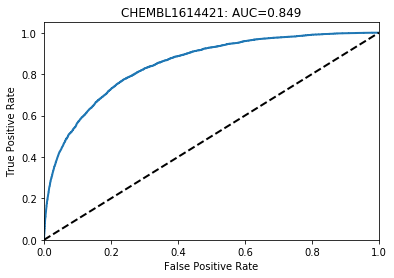
        </td>
        <td>
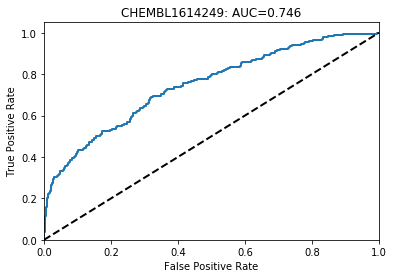
        </td>
    </tr>
    </table>
    
The ROC curve for assay CHEMBL1614249 shows significantly better early enrichment than that for CHEMBL1614421 and an overall better AUC.


Generality...


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\glandrum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['inf', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This is a set of data about binding to serotonin receptors exported from ChEMBL.

In [2]:
with gzip.open('../data/chembl_5HT.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


Get some info about those assays from the ChEMBL REST services:

In [3]:
import requests,json
assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('target_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/target/{k}?format=json')
    info = json.loads(resp.text)
    assay_lookup[k] = info['organism'],info['pref_name']
    print(k,v,info['organism'],info['pref_name'])

CHEMBL3371 3180 Homo sapiens Serotonin 6 (5-HT6) receptor
CHEMBL224 3068 Homo sapiens Serotonin 2a (5-HT2a) receptor
CHEMBL214 2672 Homo sapiens Serotonin 1a (5-HT1a) receptor
CHEMBL3155 1636 Homo sapiens Serotonin 7 (5-HT7) receptor
CHEMBL225 1580 Homo sapiens Serotonin 2c (5-HT2c) receptor
CHEMBL1833 922 Homo sapiens Serotonin 2b (5-HT2b) receptor
CHEMBL1898 542 Homo sapiens Serotonin 1b (5-HT1b) receptor
CHEMBL1983 525 Homo sapiens Serotonin 1d (5-HT1d) receptor
CHEMBL1899 491 Homo sapiens Serotonin 3a (5-HT3a) receptor
CHEMBL1875 369 Homo sapiens Serotonin 4 (5-HT4) receptor
CHEMBL3426 227 Homo sapiens Serotonin 5a (5-HT5a) receptor
CHEMBL2182 86 Homo sapiens Serotonin 1e (5-HT1e) receptor
CHEMBL1805 36 Homo sapiens Serotonin 1f (5-HT1f) receptor


In [5]:
with open('../data/serotonin_data.pkl','wb+') as outf:
    pickle.dump((d,assay_lookup),outf)

In [6]:
with open('../data/serotonin_data.pkl','rb') as inf:
    d,assay_lookup = pickle.load(inf)

Look at the distributions of activities for some of the assays

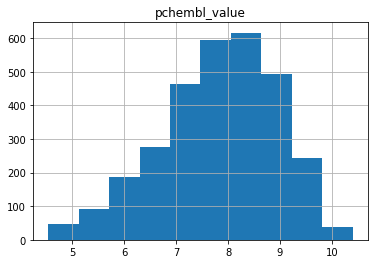

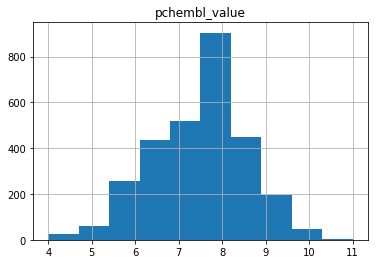

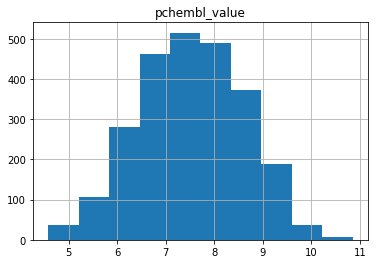

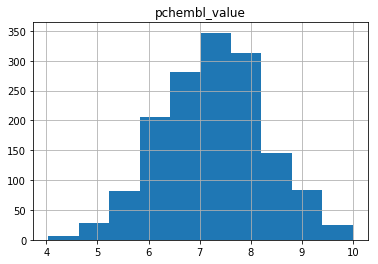

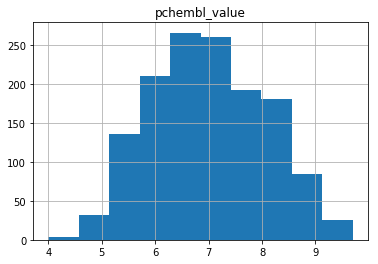

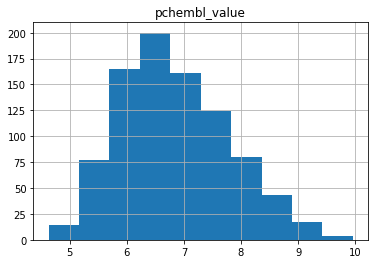

In [7]:
for v,k in tpls:
    if v>900:
        d.loc[d['target_chembl_id']==k].hist('pchembl_value');
        

Here's the function to build and evaluate a random forest for an assay. This won't build the best possible model for the assay - we aren't doing any parameter optimization and are always using the same fingerprinter - but that's beside the point for this analysis

In [8]:
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def run_it2(acts,inacts):
    # generate fingerprints for the actives and inactives and convert them to numpy arrays so that
    # we can learn from them. This uses the generalized fingerprinter added in the RDKit 2018.09 release
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))
    inact_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    # do a random, stratified 80/20 training/holdout split:
    random.seed(0xf00d)
    nAct = len(act_data)
    actis = list(range(nAct))
    nInact = len(inact_data)
    inactis = list(range(nInact))
    random.shuffle(actis)
    random.shuffle(inactis)

    train_pct = 0.80
    train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
    test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

    random.shuffle(train)
    random.shuffle(test)

    # build the random forest:
    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True)
    cls.fit([y for x,y,z in train],[z for x,y,z in train])
    oob_auroc = metrics.roc_auc_score([z for x,y,z in train],[x[1] for x in cls.oob_decision_function_])

    # generate and show some evaluation stats for the model on the holdout data:
    scores = cls.predict([y for x,y,z in test])
    probs = cls.predict_proba([y for x,y,z in test])[:,1]
    auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
    print('ratio: %.3f kappa: %.3f, AUC: %.3f, OOB_AUC: %.3f'%(nAct/nInact,metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc,oob_auroc))
    print(metrics.confusion_matrix([z for x,y,z in test],scores))
    print(metrics.classification_report([z for x,y,z in test],scores))
    
    # to allow further analysis we return a tuple with:
    #  - predicted probabilities of being active (class 1) for the holdout set
    #  - actual values for the holdout set
    #  - (actual values for the training set, OOB predicted probabilities for the training set)
    return probs,[z for x,y,z in test],([z for x,y,z in train],cls.oob_decision_function_)

In [9]:
from collections import defaultdict
def run_it_(assay_id,acts,inacts,thresholds,archive):
    print("--------- Default -----------")
    ps,tgt,oob_tpl = run_it2(acts,inacts)
    oob_tgt,oob_probs = oob_tpl
    oob_probs = [x[1] for x in oob_probs]
    auroc = metrics.roc_auc_score(oob_tgt, oob_probs)
    scores = [1 if x>=0.5 else 0 for x in ps]
    kappa = metrics.cohen_kappa_score(tgt,scores)
    confusion = metrics.confusion_matrix(tgt,scores)
    archive[assay_id].append((0.5,kappa,confusion,auroc))
    print("--------- Balanced -----------")
    if thresholds is None:
        threshs = np.arange(0.05,0.55,0.05)
        tscores = []
        for thresh in threshs:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(oob_tgt,scores)
            tscores.append((np.round(kappa,3),thresh))
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
        thresholds = [thresh]
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        kappa = metrics.cohen_kappa_score(tgt,scores)
        confusion = metrics.confusion_matrix(tgt,scores)
        archive[assay_id].append((thresh,kappa,confusion,None))
        print('thresh: %.3f kappa: %.3f'%(thresh,kappa))
        print(confusion)        

def run_serotonin_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    # these need to be converted into a classification problem.
    # start with a pretty strict cutoff for active/inactive:
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)>=50:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    else:
        # but relax that if we don't end up with a reasonable number of actives:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    run_it_(assay_id,acts,inacts,thresholds,archive)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [10]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k,d,assay_lookup,archive=serotonin_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
ratio: 0.189 kappa: 0.627, AUC: 0.968, OOB_AUC: 0.950
[[417  11]
 [ 34  47]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95       428
          1       0.81      0.58      0.68        81

avg / total       0.91      0.91      0.91       509

--------- Balanced -----------
thresh: 0.300 kappa: 0.788
[[409  19]
 [ 11  70]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL224, organism: Homo sapiens, target: Serotonin 2a (5-HT2a) receptor
--------- Default -----------
ratio: 0.085 kappa: 0.714, AUC: 0.989, OOB_AUC: 0.957
[[494   2]
 [ 17  26]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       496
          1       0.93      0.60      0.73        43



Now we'll work with the "Dataset 1" datasets from the benchmarking set. These are collections of diverse actives from various ChEMBL targets together with assumed inactives pulled from an older version of ZINC.

In [15]:
import glob
datasets = glob.glob('../../benchmarking_platform/compounds/ChEMBL/cmp_list*_actives.dat.gz')
print(len(datasets))
random.seed(0xf00d)
random.shuffle(datasets)
keep = datasets[:20]
keep[:5]

80


['../../benchmarking_platform/compounds/ChEMBL\\cmp_list_ChEMBL_43_actives.dat.gz',
 '../../benchmarking_platform/compounds/ChEMBL\\cmp_list_ChEMBL_12670_actives.dat.gz',
 '../../benchmarking_platform/compounds/ChEMBL\\cmp_list_ChEMBL_100166_actives.dat.gz',
 '../../benchmarking_platform/compounds/ChEMBL\\cmp_list_ChEMBL_65_actives.dat.gz',
 '../../benchmarking_platform/compounds/ChEMBL\\cmp_list_ChEMBL_12209_actives.dat.gz']

In [16]:
import re
with gzip.open('../../benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz') as inf:
    inactive_df = pd.read_csv(inf,sep='\t')

chembl_active_sets = {}
for fn in datasets:
    nm = re.search(r'cmp_list_(ChEMBL_[0-9]*)_actives',fn).groups()[0]
    with gzip.open(fn) as inf:
        chembl_active_sets[nm] = pd.read_csv(inf,sep='\t')

In [17]:
def run_dataset1_assay(assay_id,chembl_active_sets,inactive_df,factor=20,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = chembl_active_sets[assay_id]
    acts = assay.rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})
    inacts = inactive_df.sample(n=factor*len(acts),random_state=hash(assay_id)%0xf00d).rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}')

    run_it_(assay_id,acts,inacts,thresholds,archive)    
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [19]:
ds1_archive = defaultdict(list)
for k in chembl_active_sets:
    run_dataset1_assay(k,chembl_active_sets,inactive_df,archive=ds1_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_43
--------- Default -----------
ratio: 0.050 kappa: 0.175, AUC: 0.869, OOB_AUC: 0.878
[[400   0]
 [ 18   2]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.10      0.18        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.486
[[399   1]
 [ 13   7]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12670
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.990, OOB_AUC: 0.979
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.821
[[396   4]
 

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.091, AUC: 0.991, OOB_AUC: 0.976
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.704
[[395   5]
 [  6  14]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_237
--------- Default -----------
ratio: 0.050 kappa: 0.816, AUC: 0.986, OOB_AUC: 0.994
[[400   0]
 [  6  14]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       400
          1       1.00      0.70      0.82        20

avg / total       0.99      0.99      0.98       420

--------- Balanced -----------
thresh: 0.300 kappa: 0.945
[[400   0]
 [  2  18]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.175, AUC: 0.976, OOB_AUC: 0.986
[[400   0]
 [ 18   2]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.10      0.18        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.652
[[396   4]
 [  8  12]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_219
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.966, OOB_AUC: 0.982
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.591
[[397   3]
 [ 10  10]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.559, AUC: 1.000, OOB_AUC: 1.000
[[400   0]
 [ 12   8]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       400
          1       1.00      0.40      0.57        20

avg / total       0.97      0.97      0.97       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.915
[[400   0]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_104
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.992, OOB_AUC: 0.958
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.676
[[399   1]
 [  9  11]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.252, AUC: 0.981, OOB_AUC: 0.987
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.718
[[394   6]
 [  5  15]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_165
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.908, OOB_AUC: 0.924
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.100 kappa: 0.507
[[387  13]
 [  8  12]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.915, AUC: 1.000, OOB_AUC: 1.000
[[400   0]
 [  3  17]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       400
          1       1.00      0.85      0.92        20

avg / total       0.99      0.99      0.99       420

--------- Balanced -----------
thresh: 0.150 kappa: 1.000
[[400   0]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10498
--------- Default -----------
ratio: 0.050 kappa: 0.323, AUC: 0.995, OOB_AUC: 0.996
[[400   0]
 [ 16   4]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.20      0.33        20

avg / total       0.96      0.96      0.95       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.851
[[400   0]
 [  5  15]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.449, AUC: 0.973, OOB_AUC: 0.982
[[400   0]
 [ 14   6]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       400
          1       1.00      0.30      0.46        20

avg / total       0.97      0.97      0.96       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.742
[[392   8]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11631
--------- Default -----------
ratio: 0.050 kappa: 0.700, AUC: 0.996, OOB_AUC: 0.988
[[400   0]
 [  9  11]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.55      0.71        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.872
[[397   3]
 [  2  18]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.915, AUC: 1.000, OOB_AUC: 1.000
[[400   0]
 [  3  17]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       400
          1       1.00      0.85      0.92        20

avg / total       0.99      0.99      0.99       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.974
[[399   1]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_87
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.885, OOB_AUC: 0.919
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.292
[[398   2]
 [ 16   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.884, AUC: 1.000, OOB_AUC: 1.000
[[400   0]
 [  4  16]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       400
          1       1.00      0.80      0.89        20

avg / total       0.99      0.99      0.99       420

--------- Balanced -----------
thresh: 0.150 kappa: 1.000
[[400   0]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_130
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.950, OOB_AUC: 0.976
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.669
[[395   5]
 [  7  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.449, AUC: 0.997, OOB_AUC: 0.985
[[400   0]
 [ 14   6]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       400
          1       1.00      0.30      0.46        20

avg / total       0.97      0.97      0.96       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10188
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.939, OOB_AUC: 0.928
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.826
[[399   1]
 [  5  15]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.978, OOB_AUC: 0.957
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.594
[[395   5]
 [  9  11]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10260
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.091, AUC: 0.990, OOB_AUC: 0.963
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.828
[[395   5]
 [  2  18]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_116
--------- Default -----------
ratio: 0.050 kappa: 0.700, AUC: 0.999, OOB_AUC: 0.997
[[400   0]
 [  9  11]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.55      0.71        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.948
[[399   1]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.091, AUC: 0.972, OOB_AUC: 0.962
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.559
[[400   0]
 [ 12   8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11336
--------- Default -----------
ratio: 0.050 kappa: 0.741, AUC: 0.998, OOB_AUC: 0.999
[[400   0]
 [  8  12]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.60      0.75        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.816
[[393   7]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.945, AUC: 1.000, OOB_AUC: 1.000
[[400   0]
 [  2  18]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       400
          1       1.00      0.90      0.95        20

avg / total       1.00      1.00      1.00       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12911
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.946, OOB_AUC: 0.905
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.100 kappa: 0.543
[[380  20]
 [  4  16]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.967, OOB_AUC: 0.930
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.710
[[397   3]
 [  7  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10927
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.816, AUC: 1.000, OOB_AUC: 0.999
[[400   0]
 [  6  14]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       400
          1       1.00      0.70      0.82        20

avg / total       0.99      0.99      0.98       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11085
--------- Default -----------
ratio: 0.050 kappa: 0.449, AUC: 0.993, OOB_AUC: 0.992
[[400   0]
 [ 14   6]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       400
          1       1.00      0.30      0.46        20

avg / total       0.97      0.97      0.96       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.948
[[399   1]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 2.,  1.,  3.,  3.,  2.,  2.,  9.,  7., 23., 28.]),
 array([0.87817188, 0.89035469, 0.9025375 , 0.91472031, 0.92690312,
        0.93908594, 0.95126875, 0.96345156, 0.97563437, 0.98781719,
        1.        ]),
 <a list of 10 Patch objects>)

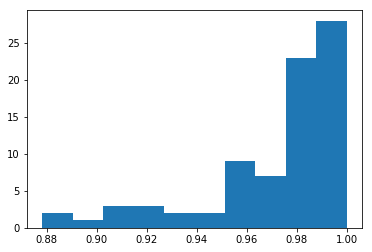

In [23]:
plt.hist([x[0][-1] for x in ds1_archive.values()])

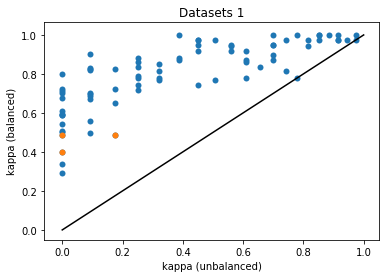

In [24]:
initVs = [x[0][1] for x in ds1_archive.values()]
finalVs = [x[1][1] for x in ds1_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
initVs = [x[0][1] for x in ds1_archive.values() if x[0][-1]<=0.9]
finalVs = [x[1][1] for x in ds1_archive.values() if x[0][-1]<=0.9]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('Datasets 1');

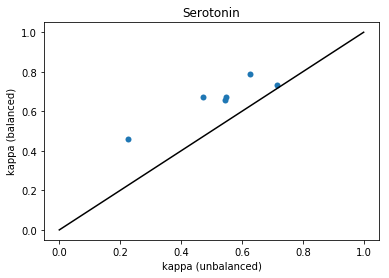

In [25]:
initVs = [x[0][1] for x in serotonin_archive.values()]
finalVs = [x[1][1] for x in serotonin_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('Serotonin');

# PubChem HTS Validation assays found in ChEMBL

In [42]:
with gzip.open('../data/ChEMBL_PubChem_HTS.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.Br.C(c1ccncc1)c2cnc[nH]2,CHEMBL1316355,CHEMBL1614421,=,44668.4,Inconclusive
1,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614249,=,31622.8,Not Active
2,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614364,=,446.7,Not Active
3,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614421,=,17782.8,Inconclusive
4,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1794375,NaN,35481.3,active


In [27]:
import requests,json
pubchem_assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('assay_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/assay/{k}?format=json')
    info = json.loads(resp.text)
    pubchem_assay_lookup[k] = info['description']
    print(k,v,info['description'])

CHEMBL1794375 83178 PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
CHEMBL1614421 49035 PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]
CHEMBL1614249 42030 PUBCHEM_BIOASSAY: qHTS Assay for Identification of Novel General Anesthetics. In this assay, a GABAergic mimetic model system, apoferritin and a profluorescent 1-aminoanthracene ligand (1-AMA), was used to construct a competitive binding assay for identification of novel general anesthetics (Class of assay: confirmatory) [Related pubchem assays: 2385 (Probe Development Summary for Identification of Novel General Anesthetics), 2323 (Validation apoferritin assay run on SigmaAldrich LOPAC1280 collection)]
CHEMBL1614166 34201 PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA bi

In [28]:
with open('../data/pubchem_data.pkl','wb+') as outf:
    pickle.dump((d,pubchem_assay_lookup),outf)

In [29]:
with open('../data/pubchem_data.pkl','rb') as inf:
    d,pubchem_assay_lookup = pickle.load(inf)

In [30]:
def run_pubchem_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = d.loc[d['assay_chembl_id']==assay_id]
    acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                      assay.loc[assay['activity_comment'] == 'active']))
    inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                        assay.loc[assay['activity_comment'] == 'inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Not Active']))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    run_it_(assay_id,acts,inacts,thresholds,archive)       
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [31]:
pubchem_archive = defaultdict(list)
for k in pubchem_assay_lookup:
    run_pubchem_assay(k,d,pubchem_assay_lookup,archive=pubchem_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1794375, description: PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
--------- Default -----------
ratio: 0.057 kappa: 0.002, AUC: 0.703, OOB_AUC: 0.695
[[15738     0]
 [  897     1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     15738
          1       1.00      0.00      0.00       898

avg / total       0.95      0.95      0.92     16636

--------- Balanced -----------
thresh: 0.100 kappa: 0.133
[[15559   179]
 [  808    90]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614421, description: PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


thresh: 0.050 kappa: 0.102
[[8302   54]
 [  45    6]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614166, description: PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA binding.   (Class of assay: confirmatory) 
--------- Default -----------
ratio: 0.003 kappa: 0.181, AUC: 0.879, OOB_AUC: 0.776
[[6821    0]
 [  18    2]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6821
          1       1.00      0.10      0.18        20

avg / total       1.00      1.00      1.00      6841

--------- Balanced -----------
thresh: 0.100 kappa: 0.469
[[6815    6]
 [  12    8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614364, description: PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of Tyrosyl-DNA Phosphodiesterase (TDP1). (Class of assay: confirmatory) 
--------- Defa

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.257 kappa: 0.122, AUC: 0.810, OOB_AUC: 0.802
[[695   5]
 [164  16]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89       700
          1       0.76      0.09      0.16       180

avg / total       0.80      0.81      0.74       880

--------- Balanced -----------
thresh: 0.250 kappa: 0.425
[[617  83]
 [ 82  98]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3215169, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Lassa Virus.   (Class of assay: confirmatory) 
--------- Default -----------
ratio: 0.215 kappa: 0.230, AUC: 0.743, OOB_AUC: 0.764
[[531   4]
 [ 96  19]]
             precision    recall  f1-score   support

          0       0.85      0.99      0.91       535
          1       0.83      0.17      0.28       115

avg / total       0.84      0.85      0.80       650

--------- Balanced -----------
thresh:

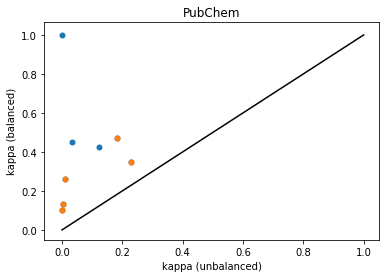

In [32]:
initVs = [x[0][1] for x in pubchem_archive.values()]
finalVs = [x[1][1] for x in pubchem_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
initVs = [x[0][1] for x in pubchem_archive.values() if x[0][-1]<=0.8]
finalVs = [x[1][1] for x in pubchem_archive.values() if x[0][-1]<=0.8]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('PubChem');

One that didn't work very well: CHEMBL1614249

One that worked well: CHEMBL1614421

251 41779
ratio: 0.006 kappa: 0.000, AUC: 0.708, OOB_AUC: 0.746
[[8356    0]
 [  51    0]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      8356
          1       0.00      0.00      0.00        51

avg / total       0.99      0.99      0.99      8407



C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


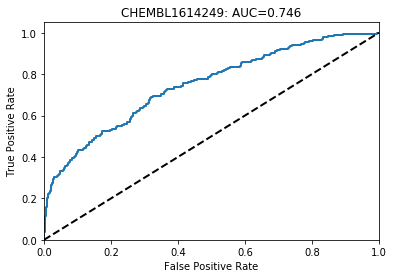

In [55]:
aid = 'CHEMBL1614249'
assay = d.loc[d['assay_chembl_id']==aid]
acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                  assay.loc[assay['activity_comment'] == 'active']))
inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                    assay.loc[assay['activity_comment'] == 'inconclusive'], 
                    assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                    assay.loc[assay['activity_comment'] == 'Not Active']))
print(len(acts),len(inacts))
ps,tgt,oob_tpl = run_it2(acts,inacts)
oob_tgt,oob_probs = oob_tpl
oob_probs = [x[1] for x in oob_probs]
auroc = metrics.roc_auc_score(oob_tgt, oob_probs)
scores = [1 if x>=0.5 else 0 for x in ps]
kappa = metrics.cohen_kappa_score(tgt,scores)
confusion = metrics.confusion_matrix(tgt,scores)
fpr,tpr,_ = metrics.roc_curve(oob_tgt,oob_probs);
plt.figure()
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("%s: AUC=%.3f"%(aid,auroc))
plt.show()

5614 43421
ratio: 0.129 kappa: 0.032, AUC: 0.860, OOB_AUC: 0.849
[[8681    4]
 [1102   21]]
             precision    recall  f1-score   support

          0       0.89      1.00      0.94      8685
          1       0.84      0.02      0.04      1123

avg / total       0.88      0.89      0.84      9808



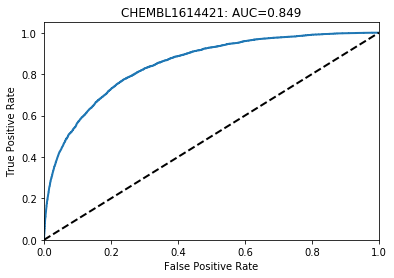

In [56]:
aid = 'CHEMBL1614421'
assay = d.loc[d['assay_chembl_id']==aid]
acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                  assay.loc[assay['activity_comment'] == 'active']))
inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                    assay.loc[assay['activity_comment'] == 'inconclusive'], 
                    assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                    assay.loc[assay['activity_comment'] == 'Not Active']))
print(len(acts),len(inacts))
ps,tgt,oob_tpl = run_it2(acts,inacts)
oob_tgt,oob_probs = oob_tpl
oob_probs = [x[1] for x in oob_probs]
auroc = metrics.roc_auc_score(oob_tgt, oob_probs)
scores = [1 if x>=0.5 else 0 for x in ps]
kappa = metrics.cohen_kappa_score(tgt,scores)
confusion = metrics.confusion_matrix(tgt,scores)
fpr,tpr,_ = metrics.roc_curve(oob_tgt,oob_probs);
plt.figure()
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("%s: AUC=%.3f"%(aid,auroc))
plt.show()

# ChEMBL DrugMatrix assays

In [33]:
with gzip.open('../data/ChEMBL_DrugMatrix.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
1,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
2,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909213,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
3,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909214,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
4,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909215,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...


In [34]:
import requests,json
drugmatrix_assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('assay_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    # we will only keep the subset of assays that have enough actives,
    assay = d.loc[d['assay_chembl_id']==k]
    if(len([1 for y in assay['activity_comment'] if y.find('Active')==0])<40):
        #print(f'Skipping assay: {k}')
        continue
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/assay/{k}?format=json')
    info = json.loads(resp.text)
    drugmatrix_assay_lookup[k] = info['description']
    print(k,v,info['description'])
#     drugmatrix_assay_lookup[k] = k
#     print(k,v)

CHEMBL1909215 842 DRUGMATRIX: Adenosine A3 radioligand binding (ligand: AB-MECA)
CHEMBL1909211 842 DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT2A radioligand binding (ligand: [3H] Ketanserin)
CHEMBL1909210 842 DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT1B radioligand binding (ligand: [125I] Cyanopindolol)
CHEMBL1909209 842 DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT1A radioligand binding (ligand: [3H] 8-OH-DPAT)
CHEMBL1909204 842 DRUGMATRIX: Protein Tyrosine Kinase, Fyn enzyme inhibition (substrate: Poly(Glu:Tyr))
CHEMBL1909203 842 DRUGMATRIX: Protein Tyrosine Kinase, EGF Receptor enzyme inhibition (substrate: Poly(Glu:Tyr))
CHEMBL1909191 842 DRUGMATRIX: Progesterone radioligand binding (ligand: [3H] R-5020)
CHEMBL1909174 842 DRUGMATRIX: Muscarinic M5 radioligand binding (ligand: [3H] N-Methylscopolamine)
CHEMBL1909173 842 DRUGMATRIX: Muscarinic M4 radioligand binding (ligand: [3H] N-Methylscopolamine)
CHEMBL1909172 842 DRUGMATRIX: Muscarinic M3 radioligand binding (ligan

In [35]:
with open('../data/drugmatrix_data.pkl','wb+') as outf:
    pickle.dump((d,drugmatrix_assay_lookup),outf)

In [36]:
with open('../data/drugmatrix_data.pkl','rb') as inf:
    d,drugmatrix_assay_lookup = pickle.load(inf)

In [37]:
from collections import defaultdict
def run_drugmatrix_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = d.loc[d['assay_chembl_id']==assay_id]
    inact_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Not Active')==0]
    act_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Active')==0]
    acts = assay.iloc[act_indices]
    inacts = assay.iloc[inact_indices]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')

    if(len(act_indices)<40):
        print(f'>>>>> SKIPPING {assay_id} DUE TO INSUFFICIENT ACTIVES <<<<<< ')
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')
        return

    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    run_it_(assay_id,acts,inacts,thresholds,archive)       

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [38]:
drugmatrix_archive = defaultdict(list)
for k in drugmatrix_assay_lookup:
    run_drugmatrix_assay(k,d,drugmatrix_assay_lookup,archive=drugmatrix_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909215, description: DRUGMATRIX: Adenosine A3 radioligand binding (ligand: AB-MECA)
--------- Default -----------
ratio: 0.073 kappa: 0.000, AUC: 0.822, OOB_AUC: 0.849
[[157   0]
 [ 12   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       157
          1       0.00      0.00      0.00        12

avg / total       0.86      0.93      0.89       169

--------- Balanced -----------
thresh: 0.250 kappa: 0.245
[[156   1]
 [ 10   2]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909211, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT2A radioligand binding (ligand: [3H] Ketanserin)
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.127 kappa: 0.301, AUC: 0.924, OOB_AUC: 0.931
[[149   1]
 [ 15   4]]
             precision    recall  f1-score   support

          0       0.91      0.99      0.95       150
          1       0.80      0.21      0.33        19

avg / total       0.90      0.91      0.88       169

--------- Balanced -----------
thresh: 0.300 kappa: 0.673
[[147   3]
 [  7  12]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909210, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT1B radioligand binding (ligand: [125I] Cyanopindolol)
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.804, OOB_AUC: 0.918
[[161   0]
 [  8   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       161
          1       0.00      0.00      0.00         8

avg / total       0.91      0.95      0.93       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.40

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.089 kappa: 0.308, AUC: 0.920, OOB_AUC: 0.915
[[154   1]
 [ 11   3]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       155
          1       0.75      0.21      0.33        14

avg / total       0.92      0.93      0.91       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.611
[[150   5]
 [  5   9]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909204, description: DRUGMATRIX: Protein Tyrosine Kinase, Fyn enzyme inhibition (substrate: Poly(Glu:Tyr))
--------- Default -----------
ratio: 0.066 kappa: 0.000, AUC: 0.770, OOB_AUC: 0.892
[[158   0]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.97       158
          1       0.00      0.00      0.00        11

avg / total       0.87      0.93      0.90       169

--------- Balanced -----------
thresh: 0.100 kappa: 0.385
[[144  14]
 [ 

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.921, OOB_AUC: 0.856
[[161   0]
 [  8   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       161
          1       0.00      0.00      0.00         8

avg / total       0.91      0.95      0.93       169

--------- Balanced -----------
thresh: 0.100 kappa: 0.273
[[148  13]
 [  4   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909191, description: DRUGMATRIX: Progesterone radioligand binding (ligand: [3H] R-5020)
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.060 kappa: 0.556, AUC: 0.970, OOB_AUC: 0.939
[[159   0]
 [  6   4]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       159
          1       1.00      0.40      0.57        10

avg / total       0.97      0.96      0.96       169

--------- Balanced -----------
thresh: 0.250 kappa: 0.883
[[159   0]
 [  2   8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909174, description: DRUGMATRIX: Muscarinic M5 radioligand binding (ligand: [3H] N-Methylscopolamine)
--------- Default -----------
ratio: 0.084 kappa: 0.228, AUC: 0.955, OOB_AUC: 0.915
[[155   1]
 [ 11   2]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       156
          1       0.67      0.15      0.25        13

avg / total       0.91      0.93      0.91       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.487
[[152   4]
 [  7   

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.078 kappa: 0.115, AUC: 0.927, OOB_AUC: 0.902
[[156   1]
 [ 12   1]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       157
          1       0.50      0.08      0.13        13

avg / total       0.90      0.92      0.90       170

--------- Balanced -----------
thresh: 0.200 kappa: 0.417
[[150   7]
 [  7   6]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909170, description: DRUGMATRIX: Muscarinic M1 radioligand binding (ligand: [3H] N-Methylscopolamine)
--------- Default -----------
ratio: 0.086 kappa: 0.091, AUC: 0.943, OOB_AUC: 0.912
[[153   2]
 [ 13   1]]
             precision    recall  f1-score   support

          0       0.92      0.99      0.95       155
          1       0.33      0.07      0.12        14

avg / total       0.87      0.91      0.88       169

--------- Balanced -----------
thresh: 0.300 kappa: 0.323
[[151   4]
 [ 10   

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.078 kappa: 0.133, AUC: 0.842, OOB_AUC: 0.898
[[157   0]
 [ 12   1]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       157
          1       1.00      0.08      0.14        13

avg / total       0.93      0.93      0.90       170

--------- Balanced -----------
thresh: 0.200 kappa: 0.642
[[154   3]
 [  5   8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909157, description: DRUGMATRIX: Histamine H2 radioligand binding (ligand: [125I] Aminopotentidine)
--------- Default -----------
ratio: 0.054 kappa: 0.000, AUC: 0.897, OOB_AUC: 0.820
[[160   0]
 [  9   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       160
          1       0.00      0.00      0.00         9

avg / total       0.90      0.95      0.92       169

--------- Balanced -----------
thresh: 0.150 kappa: 0.476
[[157   3]
 [  5   4]

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.062 kappa: 0.288, AUC: 0.964, OOB_AUC: 0.943
[[158   1]
 [  8   2]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       159
          1       0.67      0.20      0.31        10

avg / total       0.93      0.95      0.93       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.787
[[157   2]
 [  2   8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909150, description: DRUGMATRIX: Glucocorticoid radioligand binding (ligand: [3H] Dexamethasone)
--------- Default -----------
ratio: 0.059 kappa: 0.814, AUC: 0.937, OOB_AUC: 0.954
[[159   0]
 [  3   7]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       159
          1       1.00      0.70      0.82        10

avg / total       0.98      0.98      0.98       169

--------- Balanced -----------
thresh: 0.450 kappa: 0.814
[[159   0]
 [  3   7]]
*

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.120 kappa: 0.095, AUC: 0.933, OOB_AUC: 0.887
[[151   0]
 [ 17   1]]
             precision    recall  f1-score   support

          0       0.90      1.00      0.95       151
          1       1.00      0.06      0.11        18

avg / total       0.91      0.90      0.86       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.689
[[146   5]
 [  5  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909140, description: DRUGMATRIX: Dopamine D2L radioligand binding (ligand: [3H] Spiperone)
--------- Default -----------
ratio: 0.075 kappa: 0.000, AUC: 0.931, OOB_AUC: 0.931
[[157   0]
 [ 12   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       157
          1       0.00      0.00      0.00        12

avg / total       0.86      0.93      0.89       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.641
[[153   4]
 [  4   8]]
*-*-*-*

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.081 kappa: -0.011, AUC: 0.916, OOB_AUC: 0.884
[[155   1]
 [ 13   0]]
             precision    recall  f1-score   support

          0       0.92      0.99      0.96       156
          1       0.00      0.00      0.00        13

avg / total       0.85      0.92      0.88       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.394
[[151   5]
 [  8   5]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909136, description: DRUGMATRIX: CYP450, 2D6 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
--------- Default -----------
ratio: 0.095 kappa: 0.000, AUC: 0.791, OOB_AUC: 0.835
[[154   0]
 [ 15   0]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       154
          1       0.00      0.00      0.00        15

avg / total       0.83      0.91      0.87       169

--------- Balanced -----------
thresh: 0.150 kappa: 0.343
[[135  19]
 [  6   

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.063 kappa: 0.320, AUC: 0.800, OOB_AUC: 0.834
[[159   0]
 [  8   2]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       159
          1       1.00      0.20      0.33        10

avg / total       0.95      0.95      0.94       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.414
[[155   4]
 [  6   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909134, description: DRUGMATRIX: CYP450, 2C19 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
--------- Default -----------
ratio: 0.060 kappa: 0.000, AUC: 0.782, OOB_AUC: 0.715
[[159   0]
 [ 10   0]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       159
          1       0.00      0.00      0.00        10

avg / total       0.89      0.94      0.91       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.409
[[158   1]
 [  7   

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.779, OOB_AUC: 0.709
[[161   0]
 [  8   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       161
          1       0.00      0.00      0.00         8

avg / total       0.91      0.95      0.93       169

--------- Balanced -----------
thresh: 0.100 kappa: 0.305
[[150  11]
 [  4   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909130, description: DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibition (substrate: Arachidonic acid)
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.056 kappa: 0.000, AUC: 0.882, OOB_AUC: 0.822
[[160   0]
 [  9   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       160
          1       0.00      0.00      0.00         9

avg / total       0.90      0.95      0.92       169

--------- Balanced -----------
thresh: 0.150 kappa: 0.406
[[158   2]
 [  6   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909121, description: DRUGMATRIX: Calcium Channel Type L, Phenylalkylamine radioligand binding (ligand: [3H] (-)-Desmethoxyverapamil (D-888))
--------- Default -----------


C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.105 kappa: 0.108, AUC: 0.874, OOB_AUC: 0.923
[[153   0]
 [ 15   1]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       153
          1       1.00      0.06      0.12        16

avg / total       0.92      0.91      0.87       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.510
[[148   5]
 [  8   8]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909115, description: DRUGMATRIX: Androgen (Testosterone) AR radioligand binding (ligand: [3H] Mibolerone)
--------- Default -----------
ratio: 0.067 kappa: 0.158, AUC: 0.747, OOB_AUC: 0.867
[[158   0]
 [ 10   1]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       158
          1       1.00      0.09      0.17        11

avg / total       0.94      0.94      0.92       169

--------- Balanced -----------
thresh: 0.450 kappa: 0.158
[[158   0]
 [ 1

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.138 kappa: 0.192, AUC: 0.944, OOB_AUC: 0.865
[[146   2]
 [ 18   3]]
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       148
          1       0.60      0.14      0.23        21

avg / total       0.85      0.88      0.85       169

--------- Balanced -----------
thresh: 0.250 kappa: 0.634
[[140   8]
 [  6  15]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909111, description: DRUGMATRIX: Sigma2 radioligand binding (ligand: [3H] Ifenprodil)
--------- Default -----------
ratio: 0.069 kappa: 0.000, AUC: 0.904, OOB_AUC: 0.913
[[158   0]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.97       158
          1       0.00      0.00      0.00        11

avg / total       0.87      0.93      0.90       169

--------- Balanced -----------
thresh: 0.200 kappa: 0.469
[[154   4]
 [  6   5]]
*-*-*-*-*-*-

C:\Users\glandrum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.085 kappa: 0.107, AUC: 0.886, OOB_AUC: 0.897
[[155   1]
 [ 13   1]]
             precision    recall  f1-score   support

          0       0.92      0.99      0.96       156
          1       0.50      0.07      0.12        14

avg / total       0.89      0.92      0.89       170

--------- Balanced -----------
thresh: 0.200 kappa: 0.181
[[148   8]
 [ 11   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909109, description: DRUGMATRIX: Transporter, Serotonin (5-Hydroxytryptamine) (SERT) radioligand binding (ligand: [3H] Paroxetine)
--------- Default -----------
ratio: 0.121 kappa: 0.156, AUC: 0.920, OOB_AUC: 0.941
[[150   1]
 [ 17   2]]
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       151
          1       0.67      0.11      0.18        19

avg / total       0.87      0.89      0.86       170

--------- Balanced -----------
thresh: 0.200 kap

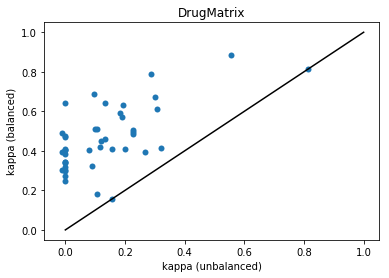

In [39]:
initVs = [x[0][1] for x in drugmatrix_archive.values()]
finalVs = [x[1][1] for x in drugmatrix_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('DrugMatrix');

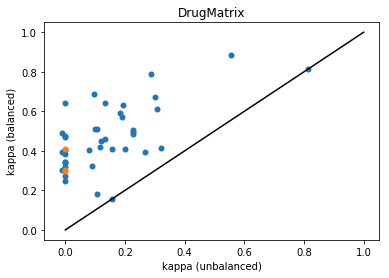

In [40]:
initVs = [x[0][1] for x in drugmatrix_archive.values() if x[0][-1]>0.8]
finalVs = [x[1][1] for x in drugmatrix_archive.values() if x[0][-1]>0.8]
plt.scatter(initVs,finalVs,linewidth=0);
initVs = [x[0][1] for x in drugmatrix_archive.values() if x[0][-1]<=0.8]
finalVs = [x[1][1] for x in drugmatrix_archive.values() if x[0][-1]<=0.8]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('DrugMatrix');

(array([ 2.,  0.,  0.,  1.,  2.,  3.,  6., 10., 12.,  8.]),
 array([0.70890211, 0.73339265, 0.7578832 , 0.78237375, 0.8068643 ,
        0.83135484, 0.85584539, 0.88033594, 0.90482649, 0.92931703,
        0.95380758]),
 <a list of 10 Patch objects>)

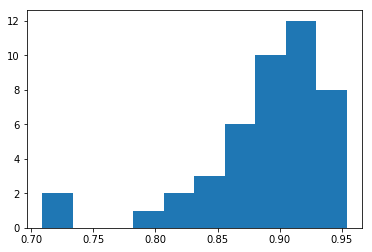

In [41]:
plt.hist([x[0][-1] for x in drugmatrix_archive.values()])